In [1]:
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
data = pd.read_csv('tox21_dataset.csv')

In [ ]:
# NR-XXX -> Nuclear Receptor
# SR-XXX -> Stress Response

'''
Each task represents a quality of cellular biology and biochemistry

['NR-AR',           Androgen Receptor
 'NR-AR-LBD',       Androgen Receptor Ligand Binding Domain
 'NR-AhR',          Aryl Hydrocarbon Receptor (response to environmental toxins)
 'NR-Aromatase',    Aromatase (enzyme that converts androgens to estrogens)
 'NR-ER',           Estrogen Receptor
 'NR-ER-LBD',       Estrogen Receptor Ligand Binding Domain
 'NR-PPAR-gamma',   Peroxisome Proliferator-Activated Receptor Gamm (fat storage and glucose)

 'SR-ARE',          Antioxidant Response Element
 'SR-ATAD5',        The ATAD5 gene is involved in DNA damage response (could lead to mutations)
 'SR-HSE',          Heat Shock Element (initiate heat shock responses)
 'SR-MMP',          Matrix Metalloproteinase (potential carcinogenic effects)
 'SR-p53']          p53 is a crucial tumor suppressor
 '''

#tasks are the 12 axis each chemical may fall into
# a molecule can be multiple classifications


# **Three Features**

In [79]:
TOX21_TASKS = ['NR-AR', 'NR-AR-LBD', 'NR-AhR']
# n_pca_features = 30


In [80]:
task_data = data.iloc[:, 0:3]
feature_data = data.iloc[:, 14:]

In [81]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(feature_data)

In [82]:
from joblib import dump, load
dump(scaler, "scaler.pkl")

['scaler.pkl']

In [83]:
task_data.head()

,NR-AR,NR-AR-LBD,NR-AhR
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [84]:
print(task_data.shape)
print(feature_data.shape)
#split the data into training and test data
features_train, features_test, task_train, task_test = train_test_split(scaled_data, task_data, test_size=0.20, random_state=42)

(7831, 3)
(7831, 226)


In [85]:
def calculate_class_weights_for_columns(y_columns):
    class_weights_dict = {}

    for col_idx in range(y_columns.shape[1]):
        column = y_columns.iloc[:, col_idx]
        unique_classes, class_counts = np.unique(column, return_counts=True)
        total_samples = len(column)
        class_weights = {}

        for class_label, class_count in zip(unique_classes, class_counts):
            class_weight = total_samples / (2.0 * class_count)
            class_weights[class_label] = class_weight

        class_weights_dict[col_idx] = class_weights

    return class_weights_dict

class_weights = calculate_class_weights_for_columns(task_train)
print("Class weights per column:", class_weights)

# '''
# {
#   0: {0: 0.5206117021276596, 1: 12.629032258064516},
#   1: {0: 0.5160652496292635, 1: 16.06153846153846},
#   2: {0: 0.5530637471304962, 1: 5.211314475873544}
# }
# '''

Class weights per column: {0: {0: 0.5206117021276596, 1: 12.629032258064516}, 1: {0: 0.5160652496292635, 1: 16.06153846153846}, 2: {0: 0.5530637471304962, 1: 5.211314475873544}}


In [86]:
sample_weights = []
for index, task in enumerate(task_train):
  cw_dict = class_weights[index]
  off_cw = cw_dict[0]
  on_cw = cw_dict[1]

  # print(off_cw, on_cw)
  task_weight = []
  # print(task)
  for x, item in enumerate(task_train[task]):
    if item == 0:
      task_weight.append(off_cw)
    if item == 1:
      task_weight.append(on_cw)

  sample_weights.append(task_weight)

print(sample_weights)
print(len(sample_weights)) # = np.array(sample_weight).T
print(len(sample_weights[0]), len(sample_weights[1]), len(sample_weights[2]))

[[0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 12.629032258064516, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596

In [87]:
features_train = np.array(features_train)

NR_AR_array = np.array(task_train.iloc[:, 0:1])
NR_AR_LBD_array = np.array(task_train.iloc[:,1:2])
NR_AhR_array = np.array(task_train.iloc[:,2:3])

In [88]:
NR_AR_weights = np.array(sample_weights[0])
NR_AR_LBD_weights = np.array(sample_weights[1])
NR_AhR_weights = np.array(sample_weights[2])

In [89]:
def build_model(features):
  xin = tf.keras.layers.Input((features.shape[1],))

  # Add a normalizer layer
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(features_train)

  xin = normalizer(xin)


  x0 = tf.keras.layers.Dense(64, activation='relu')(xin)
  x0 = tf.keras.layers.Dropout(0.42)(x0)

  x1 = tf.keras.layers.Dense(64, activation='relu')(x0)
  x1 = tf.keras.layers.Dropout(0.42)(x1)

  outputs = list()
  for _task in TOX21_TASKS:
    outputs.append(tf.keras.layers.Dense(1, activation='sigmoid', name=_task)(x0))

  return tf.keras.models.Model(inputs = xin, outputs = outputs)


In [90]:
myModel = build_model(features_train)

In [91]:
myModel.compile(loss = ['binary_crossentropy']*len(TOX21_TASKS), metrics=[["AUC", "f1_score"], ["AUC", "f1_score"], ["AUC", "f1_score"]], optimizer=Adam(learning_rate=0.001))

In [92]:
myModel.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_36CLONE      │ (None, 226)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │         14,528 │ keras_tensor_36CLONE[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_7[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-AR (Dense)             │ (None, 1)              │             65 │ dropout_7[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-AR-LBD (Dense)         │ (None, 1)              │             65 │ dropout_7[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-AhR (Dense)            │ (None, 1)              │             65 │ dropout_7[1][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,723 (57.51 KB)

 Trainable params: 14,723 (57.51 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
history = myModel.fit(features_train,
                    [NR_AR_array, NR_AR_LBD_array, NR_AhR_array],
                    epochs=250,
                    batch_size=32,
                    verbose=1,
                    validation_split=0.3,
                    sample_weight = [NR_AR_weights, NR_AR_LBD_weights, NR_AhR_weights])

Epoch 1/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - NR-AR-LBD_AUC: 0.6381 - NR-AR-LBD_f1_score: 0.0670 - NR-AR-LBD_loss: 0.7904 - NR-AR_AUC: 0.6223 - NR-AR_f1_score: 0.0821 - NR-AR_loss: 0.8607 - NR-AhR_AUC: 0.5633 - NR-AhR_f1_score: 0.1677 - NR-AhR_loss: 0.7941 - loss: 2.4452 - val_NR-AR-LBD_AUC: 0.7496 - val_NR-AR-LBD_f1_score: 0.0538 - val_NR-AR-LBD_loss: 0.5224 - val_NR-AR_AUC: 0.7881 - val_NR-AR_f1_score: 0.0668 - val_NR-AR_loss: 0.5049 - val_NR-AhR_AUC: 0.8088 - val_NR-AhR_f1_score: 0.1756 - val_NR-AhR_loss: 0.5369 - val_loss: 1.5663
Epoch 2/250
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - NR-AR-LBD_AUC: 0.8185 - NR-AR-LBD_f1_score: 0.0595 - NR-AR-LBD_loss: 0.5217 - NR-AR_AUC: 0.8214 - NR-AR_f1_score: 0.0752 - NR-AR_loss: 0.5160 - NR-AhR_AUC: 0.7971 - NR-AhR_f1_score: 0.1724 - NR-AhR_loss: 0.5526 - loss: 1.5903 - val_NR-AR-LBD_AUC: 0.7645 - val_NR-AR-LBD_f1_score: 0.0538 - val_NR-AR-LBD_loss: 0.5039 - val_NR-AR_AUC: 0.8018 - val_NR-AR_f1_score: 0.0668 - val_NR-AR_loss: 0.4861 -

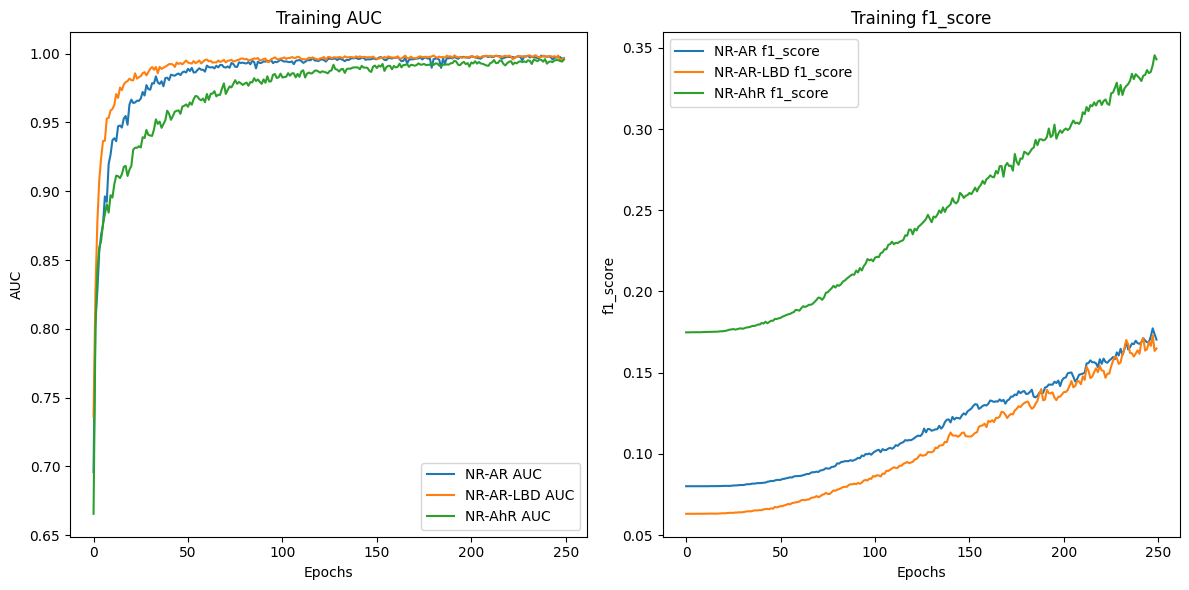

In [95]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['NR-AR_AUC'], label='NR-AR AUC')
plt.plot(history.history['NR-AR-LBD_AUC'], label='NR-AR-LBD AUC')
plt.plot(history.history['NR-AhR_AUC'], label='NR-AhR AUC')
plt.title('Training AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

#AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['NR-AR_f1_score'], label='NR-AR f1_score')
plt.plot(history.history['NR-AR-LBD_f1_score'], label='NR-AR-LBD f1_score')
plt.plot(history.history['NR-AhR_f1_score'], label='NR-AhR f1_score')
plt.title('Training f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()


plt.tight_layout()
plt.show()

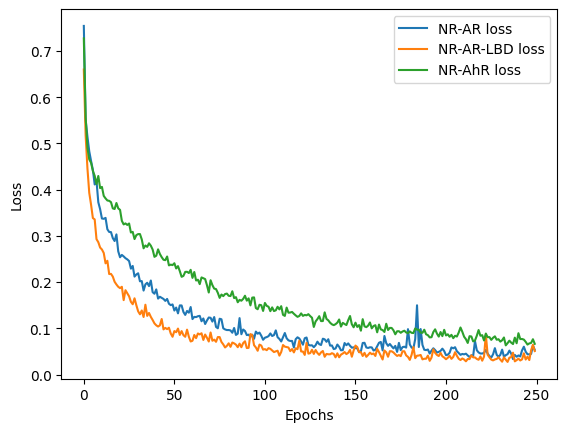

In [96]:
plt.plot(history.history['NR-AR_loss'], label='NR-AR loss')
plt.plot(history.history['NR-AR-LBD_loss'], label='NR-AR-LBD loss')
plt.plot(history.history['NR-AhR_loss'], label='NR-AhR loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [97]:
features_test = np.array(features_test)

NR_AR_array = np.array(task_test.iloc[:, 0:1])
NR_AR_LBD_array = np.array(task_test.iloc[:,1:2])
NR_AhR_array = np.array(task_test.iloc[:,2:3])

results = myModel.evaluate(features_test, [NR_AR_array, NR_AR_LBD_array, NR_AhR_array], verbose = 0)

NR_AR_loss = results[0]
NR_AR_AUC = results[3]
NR_AR_f1_score = results[4]

print("Val loss (NR-AR): ", NR_AR_loss)
print("Val AUC (NR-AR): ", NR_AR_AUC)
print("Val f1_score (NR-AR): ", NR_AR_f1_score)

# print("Val loss (NR-AR): ", NR_AR_loss)
# print("Val AUC (NR-AR): ", NR_AR_AUC)
# print("Val f1_score (NR-AR): ", NR_AR_f1_score)

# print("Val loss (NR-AR): ", NR_AR_loss)
# print("Val AUC (NR-AR): ", NR_AR_AUC)
# print("Val f1_score (NR-AR): ", NR_AR_f1_score)

Val loss (NR-AR):  2.6078810691833496
Val AUC (NR-AR):  1.1960136890411377
Val f1_score (NR-AR):  0.7849882245063782


# Example

In [98]:
scaler = StandardScaler()
scaler = load("scaler.pkl")
scaler

StandardScaler()

In [99]:
print(task_data.iloc[[3000]].to_numpy())
print(task_data.iloc[[1984]].to_numpy())

print(task_data.iloc[[1987]].to_numpy())
print(task_data.iloc[[398]].to_numpy())

[[1 1 0]]
[[0 0 0]]
[[0 0 0]]
[[1 0 1]]


In [100]:
test_input = feature_data.iloc[[3000]].to_numpy()
test_input = scaler.transform(test_input)
print(myModel.predict(test_input))

test_input = feature_data.iloc[[1984]].to_numpy()
test_input = scaler.transform(test_input)
print(myModel.predict(test_input))

test_input = feature_data.iloc[[1987]].to_numpy()
test_input = scaler.transform(test_input)
print(myModel.predict(test_input))

test_input = feature_data.iloc[[398]].to_numpy()
test_input = scaler.transform(test_input)
print(myModel.predict(test_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[array([[0.99973583]], dtype=float32), array([[0.99967843]], dtype=float32), array([[7.145063e-14]], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[array([[2.7455014e-08]], dtype=float32), array([[6.117517e-13]], dtype=float32), array([[1.129936e-13]], dtype=float32)]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[array([[0.00809776]], dtype=float32), array([[3.7529882e-10]], dtype=float32), array([[0.00031809]], dtype=float32)]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[array([[0.9700257]], dtype=float32), array([[0.00093639]], dtype=float32), array([[0.94199014]], dtype=float32)]


# Save the model

In [101]:
# assign location
path='/content/weights.weights.h5'

myModel.save(path)
print('Model Saved!')

Model Saved!
